<a href="https://colab.research.google.com/github/gmihaila/stock_risk_prediction/blob/master/notebooks/train_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info

* Main Dataset: [S&P 500 stock data](https://www.kaggle.com/camnugent/sandp500)

* Download detailes for each company: [S&P 500 Companies with Financial Information](https://datahub.io/core/s-and-p-500-companies-financials#resource-s-and-p-500-companies-financials_zip)

Stock prices are flutuated in every day. So, in each day, put those stocks in order of price change to one sentence. Then, with certain window size, each stock will show up with highly related stock frequently, because they tend to move their prices together. Source: [stock2vec repo](https://github.com/kh-kim/stock2vec)

# Imports

In [22]:
import pandas as pd
import numpy as np
import operator
import sys
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import matplotlib.patches as mpatches
import seaborn as sns

# Helper Functions

In [23]:
def sort_dict(mydict, reversed=False):
  return sorted(mydict.items(), key=operator.itemgetter(1), reverse=reversed)

# Read Data

In [24]:
# Companies description
desc_df = pd.read_csv('stocks_data/constituents.csv')
print('\nCompanies Details')
print(desc_df.head())

# stocks details
stocks_df = pd.read_csv('stocks_data/all_stocks_5yr.csv')#, parse_dates=['date'])
stocks_df_train = pd.read_csv('stocks_data/train_all_stocks_5yr.csv')
stocks_df_test = pd.read_csv('stocks_data/test_all_stocks_5yr.csv')
print('\nCompanies Stocks')
print(stocks_df.head())


Companies Details
  Symbol                 Name                  Sector
0    MMM           3M Company             Industrials
1    AOS      A.O. Smith Corp             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV          AbbVie Inc.             Health Care
4    ACN        Accenture plc  Information Technology

Companies Stocks
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL


In [25]:
# Rename the 'datetime' string column into 'date'
stocks_df_test.rename(columns={'datetime': 'date'}, inplace=True)
stocks_df_train.rename(columns={'datetime': 'date'}, inplace=True)
# Rename the 'symbol' string column into 'Name'
stocks_df_test.rename(columns={'symbol': 'Name'}, inplace=True)
stocks_df_train.rename(columns={'symbol': 'Name'}, inplace=True)
stocks_df = stocks_df_train

# Preprocess

In [26]:
stocks_df.head()

,Name,date,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
0,A,2013-02-28,41.48,42.06,41.45,41.78,3464202,-0.25,0.25,0.00,31.526668,40.19,45.350,25.000000,-75.000000,-0.377195,-0.296696,-0.069538,-26498313,-1.0
1,MTB,2013-02-28,102.09,102.77,101.55,101.77,741665,-0.56,0.56,0.00,36.680620,100.88,105.895,24.127617,-75.872383,-0.348706,-0.083759,-0.023996,-382289,-1.0
2,UNH,2013-02-28,53.45,53.96,53.39,53.82,5872088,-0.42,0.42,0.00,23.295602,52.51,58.255,16.362054,-83.637946,-0.502090,-0.351509,-0.063103,-41813055,-1.0
3,SWKS,2013-02-28,21.30,21.64,21.20,21.50,3672172,0.11,0.00,0.11,34.464025,20.28,25.100,21.161826,-78.838174,-0.449634,-0.312170,-0.146976,-13398219,1.0
4,XEL,2013-02-28,28.70,28.82,28.53,28.57,3616494,0.15,0.00,0.15,75.602587,27.65,28.820,89.743590,-10.256410,0.074566,-0.037752,0.029043,5357027,1.0


In [27]:
# dicitonary for companies name and sector
companies_names = {symbol:name for symbol, name in desc_df[['Symbol', 'Name']].values}
companies_sector = {symbol:sector for symbol, sector in desc_df[['Symbol', 'Sector']].values}

# get all companies symbols
symbols = stocks_df['Name'].values
dates = set(stocks_df['date'].values)
dates = sorted(dates)

# store each individual date and all its stocks
dates_dictionary = {date:{} for date in dates}

# Data for Word Embeddings

For each date in out dataset we rearrange each company in ascending order based on the **change in price**.

Formula for **change in price** [source](https://pocketsense.com/calculate-market-price-change-common-stock-4829.html):
* (closing_price - opening_price) / opening_price

We can change the formula to use highest price and lowest price. This is something we will test out.

In [28]:
# calculate price change for each stock and sort them in each day
for date, symbol, op, cl, in stocks_df[['date', 'Name', 'open', 'close']].values:
  # CHANGE IN PRICE: (closing_price - opening_price) / opening_price
  dates_dictionary[date][symbol] = (cl - op)/op
# sort each day reverse order
dates_dictionary = {date:sort_dict(dates_dictionary[date]) for date in dates}

stocks_w2v_data = [[value[0] for value in dates_dictionary[date]] for date in dates]

# Train Word Embeddings

In [29]:
def hash(astring):
   return ord(astring[0])

# Classifiers
We utilized classifiers to predict a stock's sector based on its daily price change to determine the quality of the Word2Vec embedding and optimal number of dimensions. After testing 4 classifiers for up to 30 dimensions, we found that the accuracy of our classifiers begins to plateau at 4 dimensions.

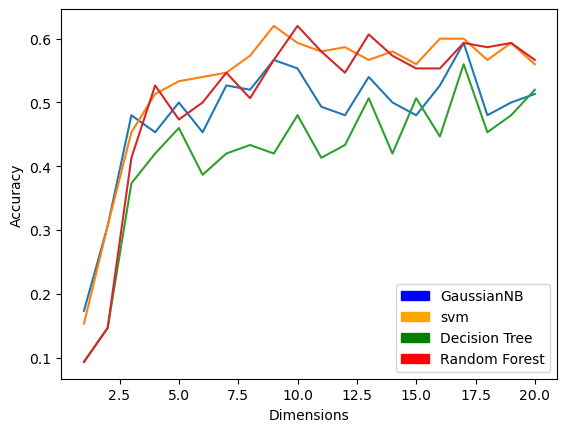

In [30]:
featureNumber = 15
labels = ['Industrials' ,'Health Care' ,'Information Technology' ,'Utilities','Financials','Materials', 
                     'Consumer Discretionary','Real Estate', 'Consumer Staples','Energy',
                     'Telecommunication Services']
counter = []
classifier1_array = []
classifier2_array = []
classifier3_array = []
classifier4_array = []

# test accuracy at various number of dimensions
for j in range(1,21):
    model = Word2Vec(stocks_w2v_data, min_count=1, vector_size=j)
    words = list(model.wv.key_to_index)  # Changed here
    X = model.wv[words]  # Changed here
    Y = list()
    for word in words:
        Y.append(companies_sector[word])

    # split data for cross validation
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    
    # predict sectors using GaussianNB, SVM, DecisionTreeClassifier and RandomForestClassifier
    model1 = GaussianNB()
    model1.fit(X_train, Y_train)
    preds1 = model1.predict(X_test)
    
    model2 = svm.SVC()
    model2.fit(X_train, Y_train)
    preds2 = model2.predict(X_test)
    
    model3 = tree.DecisionTreeClassifier()
    model3.fit(X_train, Y_train)
    preds3 = model3.predict(X_test)
    
    model4 = RandomForestClassifier()
    model4.fit(X_train, Y_train)
    preds4 = model4.predict(X_test)
    
    classifier1_array.append(accuracy_score(Y_test, preds1))
    classifier2_array.append(accuracy_score(Y_test, preds2))
    classifier3_array.append(accuracy_score(Y_test, preds3))
    classifier4_array.append(accuracy_score(Y_test, preds4))
    
    counter.append(j)

np.set_printoptions(threshold=sys.maxsize)

pyplot.plot(counter,classifier1_array)
pyplot.plot(counter,classifier2_array)
pyplot.plot(counter,classifier3_array)
pyplot.plot(counter,classifier4_array)
pyplot.ylabel('Accuracy')
pyplot.xlabel('Dimensions')
gnb_patch=mpatches.Patch(color='blue', label='GaussianNB')
svm_patch=mpatches.Patch(color='orange', label='svm')
dtc_patch=mpatches.Patch(color='green', label='Decision Tree')
rfc_patch=mpatches.Patch(color='red', label='Random Forest')
pyplot.legend(handles=[gnb_patch,svm_patch, dtc_patch, rfc_patch], loc='best')
pyplot.show()

# Plot of Variance Exlained

In [ ]:
# TODO: Doesn't work
# fit a 10D PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=10)
result = pca.fit_transform(X)
newResultX = []
newResultY = []
newWords = list()
newWordToken = ""
# read stock names from an input file (format: %AAL%)
with open('/content/drive/MyDrive/stock2vec/stock2vec-master/stocks_data/stocks.txt') as stockFile:
    contents = stockFile.read()
    for i in range(0,505):
        newWordToken = "%" + words[i] + "%"
        #if newWordToken in contents:
        newWords.append(words[i])
        newResultX.append(result[i,0])
        newResultY.append(result[i,1])

In [13]:
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum()
fig, axes = pyplot.subplots(1,1,figsize=(16,7), dpi=100)
pyplot.plot(variance_exp_cumsum, color='firebrick')
pyplot.title('Scree Plot of Variance Explained %', fontsize=22)
pyplot.xlabel('Number of Components', fontsize=16)
pyplot.ylabel('cumulative explained variance', fontsize=16)
pyplot.show()

NameError: name 'pca' is not defined

# Plot 4D Representation

In [29]:
stocks_ordered = [[value[0] for value in dates_dictionary[date]] for date in dates]
def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    fig, ax = pyplot.subplots(figsize=(20, 15)) 
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap=sns.diverging_palette(230, 30, n=9),
        ax=ax,
        annot_kws={"fontsize":20}
    )
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    pyplot.ylabel('Actual', fontsize = 20)
    pyplot.xlabel('Predicted', fontsize = 20)
    ax.set_title('Confusion Matrix', fontsize = 40, y = -.02)
    ax.set_xticklabels(class_names, fontsize=20, rotation=90)
    ax.set_yticklabels(class_names, rotation=0, fontsize = 20)
    b, t = pyplot.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    pyplot.ylim(b, t) # update the ylim(bottom, top) values
    pyplot.show() # ta-da! '''

In [19]:
# recreate model with 10 dimensions(this is the model that will be used for the rest of the code)
model = Word2Vec(stocks_w2v_data, min_count=1, vector_size=j)
words = list(model.wv.key_to_index)  # Changed here
X = model.wv[words]  # Changed here
Y = list()
for word in words:
    Y.append(companies_sector[word])

# split data set for cross validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Accuracy is  0.4605263157894737


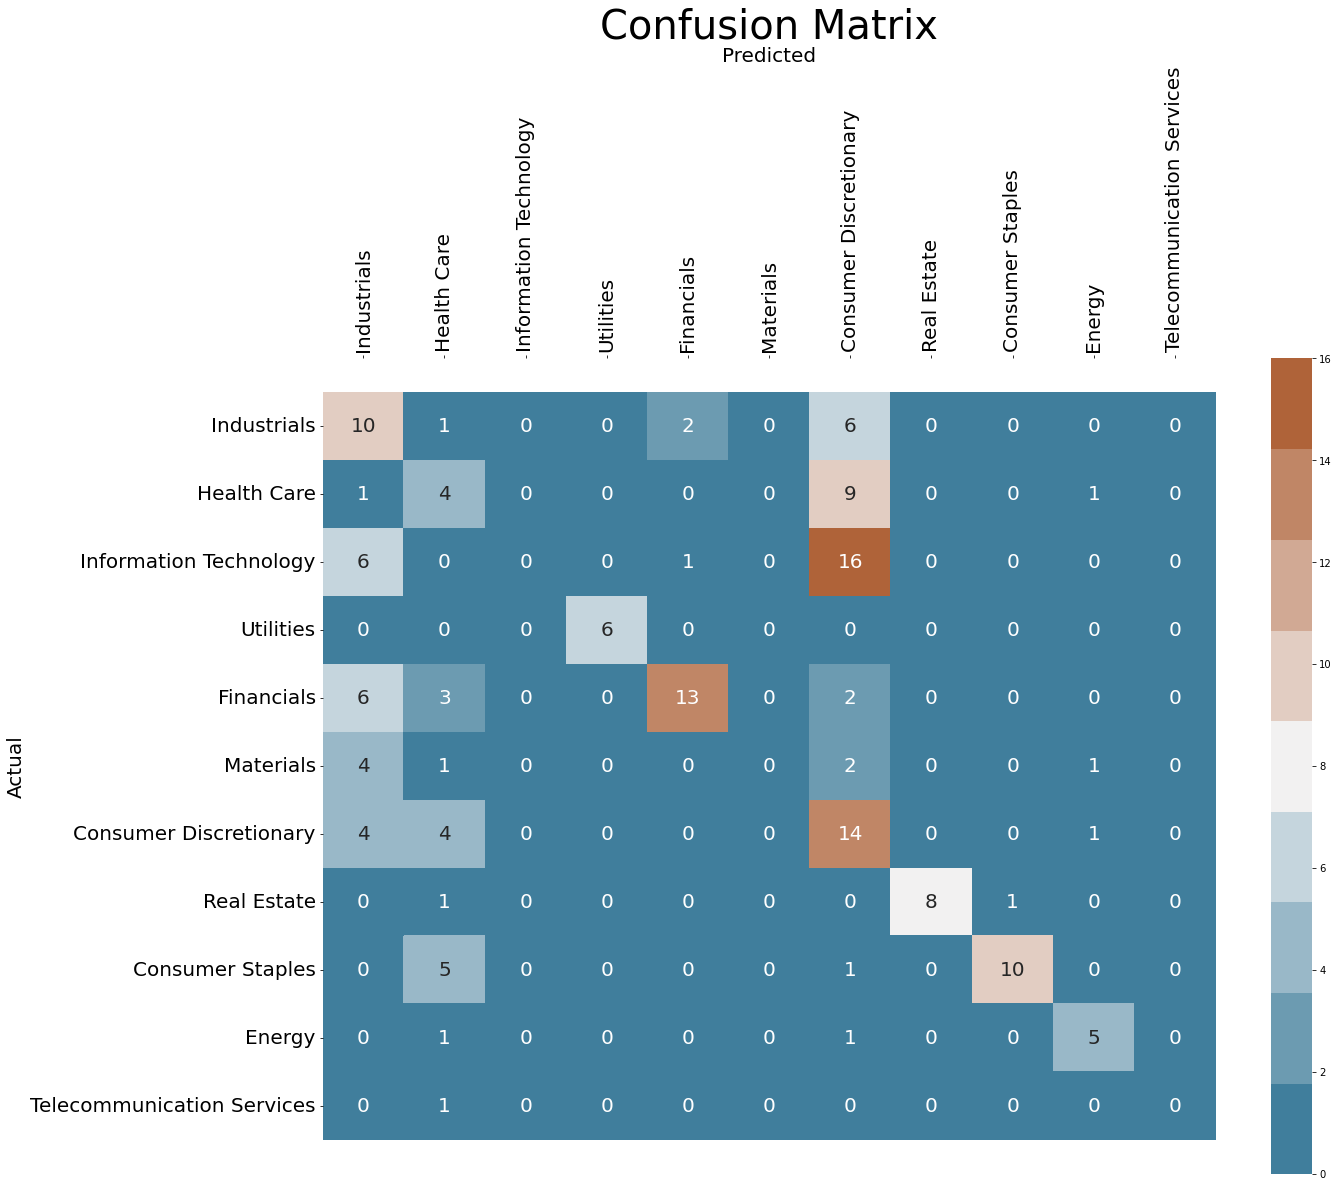

In [31]:
# plot confusion matrix for SVM classifier at 4 dimensions
model2.fit(X_train, Y_train)
preds2= model2.predict(X_test)
acc = accuracy_score(Y_test, preds2)
print("Accuracy is ", acc)
plot_cm(Y_test,preds2,labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


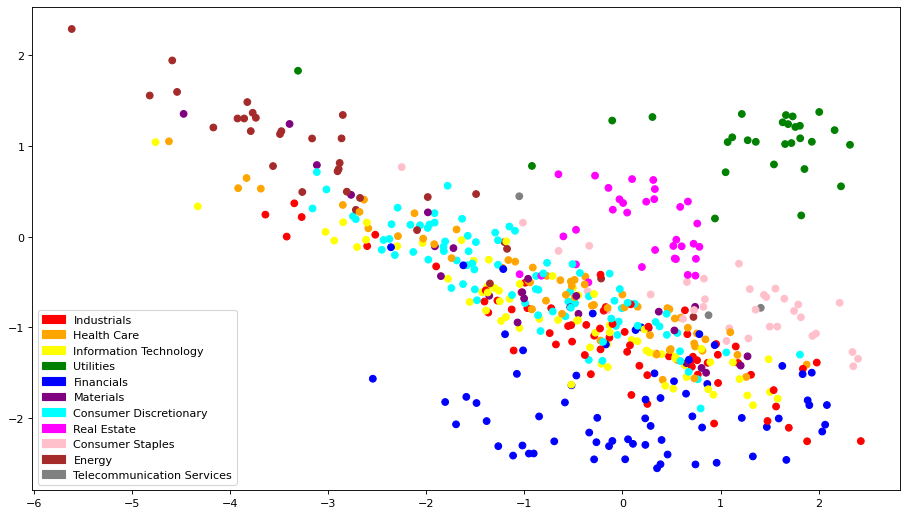

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


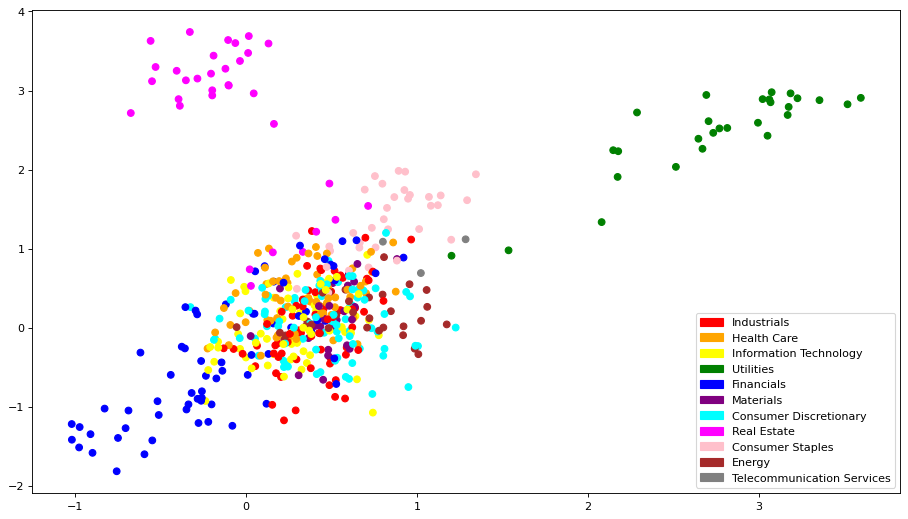

In [32]:
array1X = []
array1Y = []
array2X = []
array2Y = []

# color code by sector
sector_color_dict = {'Industrials':'red','Health Care':'orange','Information Technology':'yellow','Utilities':'green',
                     'Financials':'blue','Materials':'purple','Consumer Discretionary':'cyan','Real Estate':'magenta',
                     'Consumer Staples':'pink','Energy':'brown','Telecommunication Services':'gray'}
cvec = [sector_color_dict[companies_sector[word]] for word in words]

# legend
red_patch=mpatches.Patch(color='red', label='Industrials')
orange_patch=mpatches.Patch(color='orange', label='Health Care')
yellow_patch=mpatches.Patch(color='yellow', label='Information Technology')
green_patch=mpatches.Patch(color='green', label='Utilities')
blue_patch=mpatches.Patch(color='blue', label='Financials')
purple_patch=mpatches.Patch(color='purple', label='Materials')
cyan_patch=mpatches.Patch(color='cyan', label='Consumer Discretionary')
magenta_patch=mpatches.Patch(color='magenta', label='Real Estate')
pink_patch=mpatches.Patch(color='pink', label='Consumer Staples')
brown_patch=mpatches.Patch(color='brown', label='Energy')
gray_patch=mpatches.Patch(color='gray', label='Telecommunication Services')

# graph dimensions 1 & 2
for d in range(0,505):
    array1X.append((model[model.wv.vocab])[d,0])
    array1Y.append((model[model.wv.vocab])[d,1])
pyplot.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
pyplot.scatter(array1X[:], array1Y[:], c=cvec)
pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best')
pyplot.show()

# graph dimensions 3 & 4
for f in range(0,505):
    array2X.append((model[model.wv.vocab])[f,2])
    array2Y.append((model[model.wv.vocab])[f,3])
pyplot.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
pyplot.scatter(array2X[:], array2Y[:], c=cvec)
pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best')
pyplot.show()

# Train Word Embeddings
We're using PCA dimensionality reduction to reduce our 4D model into 2 dimensions that can easily be graphed on a coordinate plane.

In [33]:
# fit a 2D PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
newResultX = []
newResultY = []
newWords = list()
newWordToken = ""
# read stock names from an input file (format: %AAL%)
with open('/content/drive/MyDrive/stock2vec/stock2vec-master/stocks_data/stocks.txt') as stockFile:
    contents = stockFile.read()
    for i in range(0,505):
        newWordToken = "%" + words[i] + "%"
        #if newWordToken in contents:
        newWords.append(words[i])
        newResultX.append(result[i,0])
        newResultY.append(result[i,1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


# Plot 2D Representation

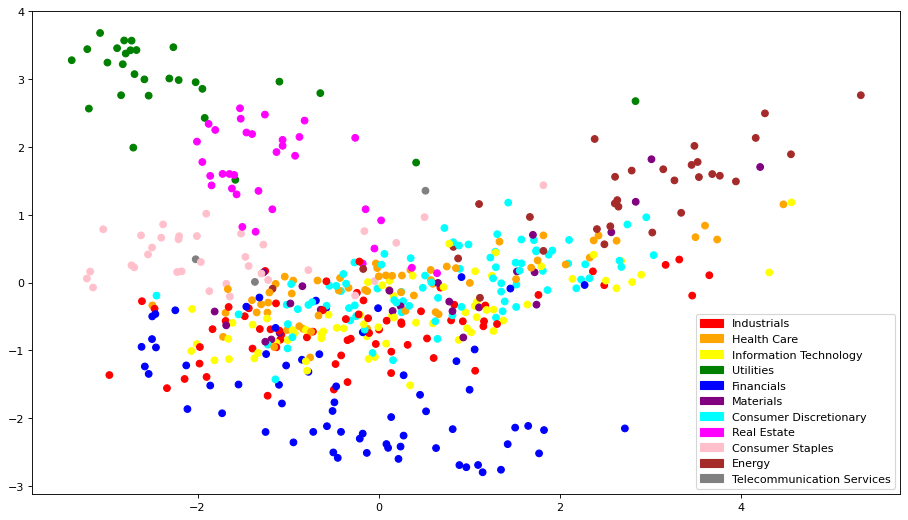

[[-8.48047793e-01 -1.13649547e+00]
 [ 5.04728854e-01  9.64639485e-01]
 [-6.56481564e-01 -1.05506325e+00]
 [ 1.08063531e+00 -2.86985368e-01]
 [ 3.64726305e+00  1.08688414e-01]
 [ 2.23245096e+00  4.55842726e-02]
 [-1.00476265e+00 -8.47992361e-01]
 [-1.25358593e+00  1.71562091e-01]
 [ 1.64845252e+00 -2.11197233e+00]
 [ 5.96348047e-01 -6.01386547e-01]
 [ 9.27051187e-01 -5.70054591e-01]
 [-3.18535304e+00  1.62777707e-01]
 [ 2.62417889e+00  6.16829395e-01]
 [ 1.28657842e+00  4.55617875e-01]
 [ 1.28908348e+00  4.42498207e-01]
 [ 1.71170974e+00  6.25770032e-01]
 [-1.45871893e-01  1.08127570e+00]
 [-1.34756660e+00 -4.39426839e-01]
 [ 2.48758316e+00 -3.79038602e-02]
 [-1.07555914e+00 -7.67841518e-01]
 [-6.30313337e-01 -7.52104342e-01]
 [ 1.09534562e+00 -2.68800688e+00]
 [-1.09709048e+00  2.96194077e+00]
 [-2.02143931e+00  2.95365524e+00]
 [ 9.73906517e-01 -6.72941327e-01]
 [-1.53212297e+00  2.56954002e+00]
 [ 1.87409616e+00  4.11061972e-01]
 [ 1.57292104e+00  6.35326087e-01]
 [ 1.64891958e-01 -1

In [34]:
#increase size of figure
pyplot.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')

# color code by sector
sector_color_dict = {'Industrials':'red','Health Care':'orange','Information Technology':'yellow','Utilities':'green',
                     'Financials':'blue','Materials':'purple','Consumer Discretionary':'cyan','Real Estate':'magenta',
                     'Consumer Staples':'pink','Energy':'brown','Telecommunication Services':'gray'}
cvec = [sector_color_dict[companies_sector[word]] for word in newWords]

# create a scatter plot of the projection
pyplot.scatter(newResultX[:], newResultY[:], c = cvec)

# labels(company symbol)
'''
for i, word in enumerate(newWords):
	#pyplot.annotate(companies_names[word], xy=(newResultX[i], newResultY[i]), fontsize = 12)
    #pyplot.annotate(word, xy=(newResultX[i], newResultY[i]))
'''

pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best')
pyplot.show()

# display eigen pairs(coordinate points)
print(result)
pca.fit(X)
eigen_vals = pca.explained_variance_
eigen_vecs = pca.components_
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
w = np.hstack((eigen_pairs[0][1][:,np.newaxis],eigen_pairs[1][1][:,np.newaxis]))
print('Matrix W;\n',w)

In [35]:
# compute average feature value for each sector(15 total features)
np.set_printoptions(threshold=sys.maxsize)

# output info to averageFeatures file
with open("/content/drive/MyDrive/stock2vec/stock2vec-master/stocks_data/averageFeatures.txt", 'w') as averageFile:
    for k in range(0, len(sectors)):
        companiesInSector = 0
        averages = []
        for i in range (0, featureNumber):
            averages.append(0.0)
        for i in range(0,505):
            if companies_sector[words[i]] == sectors[k]:
                companiesInSector += 1
                for j in range(0,featureNumber):
                    averages[j] += model[model.wv.vocab][i,j]
        for i in range (0,featureNumber):
            averages[i] /= companiesInSector;
        averageFile.write(sectors[k])
        averageFile.write(" Average Feature Numbers: ")
        averageFile.write("\n")
        for i in range(0, featureNumber):
            averageFile.write(str(averages[i]) + " ")
    
        averageFile.write("\n\n")

NameError: ignored

In [ ]:
# print similar stocks
target_symb = 'ALXN'

print('Symbol:%s\tName:%s\tSector: %s'%(target_symb, companies_names[target_symb], companies_sector[target_symb]))
top_similar = model.similar_by_word(target_symb, topn=20)
print('Most Similar')
for similar in top_similar:
  symb = similar[0]
  name = companies_names[symb]
  sect = companies_sector[symb]
  print('Symbol: %s\tName: %s\t\t\tSector: %s'%(symb, name, sect))

Symbol:ALXN	Name:Alexion Pharmaceuticals	Sector: Health Care
Most Similar
Symbol: INCY	Name: Incyte			Sector: Health Care
Symbol: VRTX	Name: Vertex Pharmaceuticals Inc			Sector: Health Care
Symbol: ILMN	Name: Illumina Inc			Sector: Health Care
Symbol: REGN	Name: Regeneron			Sector: Health Care
Symbol: MYL	Name: Mylan N.V.			Sector: Health Care
Symbol: TRIP	Name: TripAdvisor			Sector: Consumer Discretionary
Symbol: AAL	Name: American Airlines Group			Sector: Industrials
Symbol: ALK	Name: Alaska Air Group Inc			Sector: Industrials
Symbol: CNC	Name: Centene Corporation			Sector: Health Care
Symbol: LEN	Name: Lennar Corp.			Sector: Consumer Discretionary
Symbol: UAA	Name: Under Armour Class A			Sector: Consumer Discretionary
Symbol: PHM	Name: Pulte Homes Inc.			Sector: Consumer Discretionary
Symbol: QRVO	Name: Qorvo			Sector: Information Technology
Symbol: BIIB	Name: Biogen Inc.			Sector: Health Care
Symbol: AMD	Name: Advanced Micro Devices Inc			Sector: Information Technology
Symbol: DHI	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """


In [ ]:
# access vector for one word
print(model['AAL'])

[ 2.7104597   1.8147078  -0.05110195  2.1210644 ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
# Save Stoct2vec Vectors
binary_vectors = 'stoack2vec_Keyed_Binary.bin'
text_vectors = 'stoack2vec_Keyed_Text.vec'
stoack2vecKeyedBinary = model.wv.save_word2vec_format(fname=binary_vectors, binary=True)
stoack2vecKeyedText = model.wv.save_word2vec_format(fname=text_vectors, binary=False)

In [ ]:
X.shape

(505, 4)